<p align= "center">
<img width="300" src="https://logos-world.net/wp-content/uploads/2020/11/GitHub-Emblem.png" alt="Github Logo">
</p>


<h1 align = "center">Programming Language Detection</h1>

<h2 align = "center">By Chloe Whitaker, Jeanette Schulz, Brian Clements, and Paige Guajardo </h2>
<h4 align = "center">11 February 2022</h4>



<hr style="border:2px solid blue"> </hr>

# About this Project
### Github Webscraping and Natural Language Processing
Millions of developers and companies build, ship, and maintain their software on GitHub— the largest and most advanced development platform in the world. As Codeup's new up-and-coming Data Scientists, we will be using GitHub's platform to practice both our Web-Scraping skills and our Natural Language Processing (NLP) skills. With a focus on repositories that are studying bitcoin, our goal is to predict the programming language used in a repository based solely on the README.md file provided. By exploring the text provided in the README, we hope to identify key words that will allow us to identify which programming language(s) were used. Then we will teach these to our classification model so that it will predict the programming language of any future repositories we show it. For our project, we focused on five most common languages from Bitcoin repositories and named the rest 'Other'. The list of languages we will try to predict are: 
- JavaScript         
- Python             
- C++                 
- PHP                 
- C                                   
- Java   
- Other

### Project Goal: 

The goal is to scrape README pages from BitCoin related repositories on GitHub, so that we can predict the language of that repository. 

### Project Desciption: 

Language Predictor. This is a group project where we will be scraping GitHub repository README files related to BitCoin. We will then produce a classification model that will be able to predict the programming language of that repository using only the text in the README. 

<hr style="border:2px solid blue"> </hr>

### Imports

Here are the imports needed to run this notebook.

In [9]:
import pandas as pd
import numpy as np

# Scraping
import requests
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import nltk.sentiment

from wordcloud import WordCloud
# pd.set_option('display.max_colwidth', -1)

# Regex
import re

# Time
from time import strftime

import unicodedata
import json
from pprint import pprint

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Imports
# import acquire 
import prepare
import wrangle
import model
import explore

# Turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

--------

# Let's Get Started...

-----

## Wrangle

Use the wrangle.py helper file to acquire and prepare the GitHub README data. 

In [10]:
# df=acquire.make_json(cached=True)
df = pd.read_json('repo_readmes.json')

In [11]:
df.head()

,repo,language,readme_contents
0,using-system/LightningPay,C#,# LightningPay\nBitcoin Lightning Network Paym...
1,drminnaar/react-bitcoin-monitor,JavaScript,# React Bitcoin Monitor\n\nAn app that monitor...
2,lbryio/lbrycrd,C++,# LBRYcrd - The LBRY blockchain\n\n[![Build St...
3,ElementsProject/lightning-charge,JavaScript,# Lightning Charge\n\n[![build status](https:/...
4,kilimchoi/cryptocurrency,None,Check out https://coinbuddy.co/coins to track ...


In [12]:
df.shape

(180, 3)

In [13]:
# Save the names of the top 5 programming languages, and change the rest to 'Other'
df['language'] = df.language.apply(wrangle.common_language)

In [14]:
df = wrangle.brian_quick_clean(df)

In [15]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = \
wrangle.split_repos(df)

### Steps Taken to Prepare the Data:

## Exploration

### Initial Hypotheses/Questions:

#### Initial Hypothesis

Our intial thought is that a lot of the READMEs contain unique words that could help predict the language of the repository. 

#### Initial Questions: 
    1. What are the most frequently occuring words in the readmes?
    2. Are there words that uniquely identify with a certain language's repos?
    3. What are the least frequently occuring words in the readmes?
    4. Does the length of the README vary by programming language?
    5. How many repos have their programming language mentioned in the README text?
    6. Do different programming languages use a different number of unique words?

### Explore: 

To further prepare the data for explore, we will combine all of the words from the readmes together so that we can explore the entire word set as well as by language. We will also remove the common stop words and represent the contents as word frequencies.

In [16]:
# combine all contents in single string by language

javascript_words = (' '.join(train[train.language == 'JavaScript'].lemmatized))
c_plus_plus__words = (' '.join(train[train.language == 'C++'].lemmatized))
c_words = (' '.join(train[train.language == 'C'].lemmatized))
python_words = (' '.join(train[train.language == 'Python'].lemmatized))
php_words = (' '.join(train[train.language == 'PHP'].lemmatized))
java_words = (' '.join(train[train.language == 'Java'].lemmatized))
other_words = (' '.join(train[train.language == 'Other'].lemmatized))
all_words = (' '.join(train.lemmatized))

In [17]:
# remove_stopwords

javascript_words = wrangle.remove_stopwords(str(javascript_words))
c_plus_plus__words = wrangle.remove_stopwords(str(c_plus_plus__words))
c_words = wrangle.remove_stopwords(str(c_words))
python_words = wrangle.remove_stopwords(str(python_words))
java_words = wrangle.remove_stopwords(str(java_words))
php_words = wrangle.remove_stopwords(str(php_words))
other_words = wrangle.remove_stopwords(str(other_words))
all_words = wrangle.remove_stopwords(str(all_words))

In [18]:
# represent contents as word frequencies

javascript_freq = pd.Series(javascript_words.split()).value_counts()
c_plus_plus_freq = pd.Series(c_plus_plus__words.split()).value_counts()
c_freq = pd.Series(c_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
php_freq = pd.Series(php_words.split()).value_counts()
other_freq = pd.Series(other_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

We will concatinate all of the word frequencies together into a dataframe. 

In [19]:
# concat all frequencies together into a dataframe

word_counts = pd.concat([javascript_freq, c_plus_plus_freq, c_freq, python_freq, java_freq, php_freq, other_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['javascript', 'c_plus_plus', 'c', 'python', 'java', 'php', 'other', 'all']
# word_counts.head()

#### Question 1: What are the most frequently occuring words in the readmes?

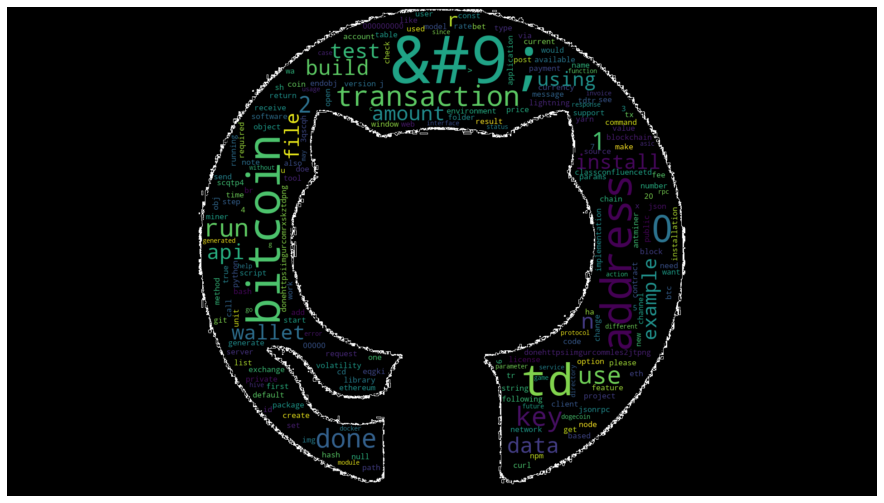

In [20]:
# word cloud of the most common words 
explore.github_logo()

In [21]:
# most frequently occuring words: sort by 'all'
word_counts.sort_values('all', ascending=False).head(20)

,javascript,c_plus_plus,c,python,java,php,other,all
&#9;,127,128,68,517,1,0,78,919
bitcoin,116,19,17,59,14,17,112,354
td,321,0,0,0,0,0,4,325
address,145,12,1,19,2,68,57,304
0,29,6,3,171,1,13,13,236
transaction,152,0,0,8,0,3,60,223
key,102,1,5,21,9,16,39,193
done,170,0,0,1,0,0,16,187
1,47,15,1,22,3,7,76,171
run,43,23,0,14,3,9,77,169


#### Question 2: Are there words that uniquely identify with a certain language's repos?

JavaScript contains the highest precentage of the 20 most common words used in the readmes. 

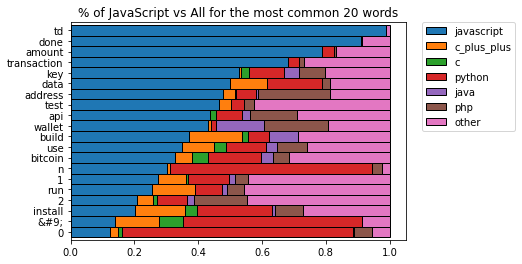

In [22]:
(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'javascript')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('% of JavaScript vs All for the most common 20 words')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);

The most common words by language: 

In [23]:
javascript_freq.idxmax(), java_freq.idxmax(), c_plus_plus_freq.idxmax(), c_freq.idxmax(), python_freq.idxmax(), java_freq.idxmax(), php_freq.idxmax(), other_freq.idxmax(), all_freq.idxmax()



('td',
 'wallet',
 '&#9;',
 '&#9;',
 '&#9;',
 'wallet',
 'address',
 'bitcoin',
 '&#9;')

#### Question 3: What are the least frequently occuring words in the readmes?

In [24]:
# most frequently occuring words: sort by 'all'
word_counts.sort_values('all', ascending=False).tail(20)

,javascript,c_plus_plus,c,python,java,php,other,all
icraorkeeycdu3,0,0,0,1,0,0,0,1
klzws,0,0,0,1,0,0,0,1
z3bu,0,0,0,1,0,0,0,1
qv,0,0,0,1,0,0,0,1
jufxc,0,0,0,1,0,0,0,1
ybsi8sn9wkoaxmwz,0,0,0,1,0,0,0,1
rg,0,0,0,1,0,0,0,1
t8w03uzjovzlf0gztoycpdeaopn8,0,0,0,1,0,0,0,1
zqt8yyxu,0,0,0,1,0,0,0,1
921,0,0,0,1,0,0,0,1


* We really dont see any key info lets see with a graph now

<Figure size 1440x720 with 0 Axes>

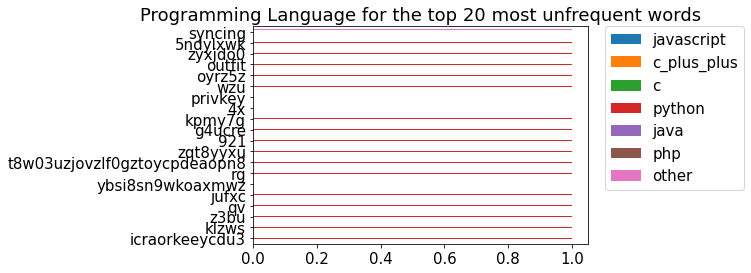

In [25]:
plt.figure(figsize=(20,10))
plt.rc('font', size=15)
word_counts.sort_values('all', ascending=False).tail(20)[['javascript',
'c_plus_plus',
'c',
'python',
'java',
'php',
'other'                                                    
]].plot.barh()
plt.title('Programming Language for the top 20 most unfrequent words')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);

* Alot of these words seem to be tied with only C++, lets take a look finally at the bottom words of all the langauges!

In [26]:
javascript_freq.idxmin(), java_freq.idxmin(), c_plus_plus_freq.idxmin(), c_freq.idxmin(), python_freq.idxmin(), java_freq.idxmin(), php_freq.idxmin(), other_freq.idxmin(), all_freq.idxmin()


('performance',
 'platformtools',
 'form',
 'usb3a',
 'k5gk',
 'platformtools',
 'sign',
 '500000376',
 'usecase')

#### Question 4: Does the length of the README vary by programming language?

In [27]:
length_list =df.groupby('language')\
.apply(lambda x: x.lemmatized.str.len().mean())
# .apply(lambda x: x/len(df[df.language]))

In [28]:
length_list

language
C             2281.750000
C++           3700.800000
Java          1414.200000
JavaScript    4489.777778
Other         4354.260000
PHP           1914.642857
Python        3034.500000
dtype: float64

In [29]:
i=0
for index in length_list.index:
    print(f"{index}'s average repo length is {length_list[i]/len(df[df.language==index])}")
    i+=1

C's average repo length is 285.21875
C++'s average repo length is 246.72
Java's average repo length is 282.84000000000003
JavaScript's average repo length is 124.71604938271604
Other's average repo length is 87.0852
PHP's average repo length is 136.76020408163265
Python's average repo length is 94.828125


- The language with the longest repos, by far, is C (using the current dataset)
- Outside of Java, the rest of the repos have an average length of roughly 200 or so lemmatized words

#### Question 5: How many repos have their programming language mentioned in the README text?

### Exploration Takeaways:

- JavaScript contains the highest percentage of the 20 most common words used in the readmes.


### Features to Move Forward with:

For features, we are going to use the TF-IDF Method to provide numeric values that we can use to model on when we pass it the lemmatized README contents. 

## Modeling

### Establishing the Baseline

The last thing we have to do before fitting (training) out models is establishing a baseline.

In [30]:
# to find the baseline, look at the value counts
train.language.value_counts(normalize=True)

Other         0.314607
JavaScript    0.224719
Python        0.202247
PHP           0.089888
C++           0.089888
C             0.044944
Java          0.033708
Name: language, dtype: float64

In [31]:
# choose the mode of the value counts
baseline = y_train.mode()

In [32]:
baseline

,language
0,Other


In [33]:
match_bsl_prediction = y_train == 'Other'

In [34]:
baseline_accuracy = match_bsl_prediction.mean()

In [35]:
# basline accuracy = 31%
baseline_accuracy

language    0.314607
dtype: float64



### Our best-performing model without undue overfitting was a Logistic Regression model

### We ran over 10 models, between a bag-of-words approach and a tf-idf approach

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

## TF-IDF Method

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.lemmatized)
y = df.language

X_train, X_validate, y_train, y_validate = train_test_split(X, y, stratify=y, \
                                                            test_size=.2)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,stratify=y_train, test_size=.2)

In [38]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))

lm = LogisticRegression().fit(X_train, y_train)

train['lr_predicted_tdidf'] = lm.predict(X_train)
validate['lr_predicted_tdidf'] = lm.predict(X_validate)

### Confustion matrix, train data

In [39]:
model.print_lr_tfidf_model_train(train)

Accuracy: 71.57%
---
Confusion Matrix
actual              C  C++  Java  JavaScript  Other  PHP  Python
lr_predicted_tdidf                                              
JavaScript          0    0     0          21      0    2       0
Other               5    8     3           2     32    7       1
Python              0    1     0           0      0    0      20
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         5
         C++       0.00      0.00      0.00         9
        Java       0.00      0.00      0.00         3
  JavaScript       0.91      0.91      0.91        23
       Other       0.55      1.00      0.71        32
         PHP       0.00      0.00      0.00         9
      Python       0.95      0.95      0.95        21

    accuracy                           0.72       102
   macro avg       0.35      0.41      0.37       102
weighted avg       0.58      0.72      0.63       102



### Confustion matrix, validate data

In [40]:
model.print_lr_tfidf_model_validate(validate)

Accuracy: 34.38%
---
Confusion Matrix
actual              C  C++  Java  JavaScript  Other  PHP  Python
lr_predicted_tdidf                                              
Other               2    3     0           7     10    3       5
Python              0    0     1           0      0    0       1
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         2
         C++       0.00      0.00      0.00         3
        Java       0.00      0.00      0.00         1
  JavaScript       0.00      0.00      0.00         7
       Other       0.33      1.00      0.50        10
         PHP       0.00      0.00      0.00         3
      Python       0.50      0.17      0.25         6

    accuracy                           0.34        32
   macro avg       0.12      0.17      0.11        32
weighted avg       0.20      0.34      0.20        32



## TF-IDF Method

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [42]:
tfidf = TfidfVectorizer()
X = vectorizer.fit_transform(df.lemmatized)
y = df.language

X_train, X_validate, y_train, y_validate = train_test_split(X, y, stratify=y, \
                                                            test_size=.2)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,stratify=y_train, test_size=.2)

In [43]:
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))

lm = LogisticRegression().fit(X_train, y_train)

train['lr_predicted_bagofwords'] = lm.predict(X_train)
validate['lr_predicted_bagofwords'] = lm.predict(X_validate)

### Confustion matrix, train data

In [44]:
model.print_lr_bagofwords_model_train(train)

Accuracy: 98.04%
---
Confusion Matrix
actual                   C  C++  Java  JavaScript  Other  PHP  Python
lr_predicted_bagofwords                                              
C                        5    0     0           0      0    0       0
C++                      0    9     0           0      0    0       0
Java                     0    0     3           0      0    0       0
JavaScript               0    0     0          22      0    0       0
Other                    0    0     0           1     32    0       1
PHP                      0    0     0           0      0    9       0
Python                   0    0     0           0      0    0      20
---
              precision    recall  f1-score   support

           C       1.00      1.00      1.00         5
         C++       1.00      1.00      1.00         9
        Java       1.00      1.00      1.00         3
  JavaScript       1.00      0.96      0.98        23
       Other       0.94      1.00      0.97        32
   

### Confustion matrix, validate data

In [45]:
model.print_lr_bagofwords_model_validate(validate)

Accuracy: 40.62%
---
Confusion Matrix
actual                   C  C++  Java  JavaScript  Other  PHP  Python
lr_predicted_bagofwords                                              
JavaScript               0    0     0           2      0    0       1
Other                    1    2     1           4      9    3       3
Python                   1    1     0           1      1    0       2
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         2
         C++       0.00      0.00      0.00         3
        Java       0.00      0.00      0.00         1
  JavaScript       0.67      0.29      0.40         7
       Other       0.39      0.90      0.55        10
         PHP       0.00      0.00      0.00         3
      Python       0.33      0.33      0.33         6

    accuracy                           0.41        32
   macro avg       0.20      0.22      0.18        32
weighted avg       0.33      0.41      0.32        32



## Our best-performing model, with the least difference between train and validate, was the TF-IDF data on the Linear Regression model; we will run it on the Test data here:

In [46]:
from sklearn.linear_model import LogisticRegression
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

test['lr_predicted'] = lm.predict(X_test)

In [47]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.lr_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.lr_predicted, test.actual))
print('---')
print(classification_report(test.actual, test.lr_predicted))

Accuracy: 53.85%
---
Confusion Matrix
actual        C  C++  Java  JavaScript  Other  PHP  Python
lr_predicted                                              
JavaScript    0    0     0           3      0    0       0
Other         1    3     1           2      7    1       1
Python        0    0     0           1      1    1       4
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         1
         C++       0.00      0.00      0.00         3
        Java       0.00      0.00      0.00         1
  JavaScript       1.00      0.50      0.67         6
       Other       0.44      0.88      0.58         8
         PHP       0.00      0.00      0.00         2
      Python       0.57      0.80      0.67         5

    accuracy                           0.54        26
   macro avg       0.29      0.31      0.27        26
weighted avg       0.48      0.54      0.46        26



## Our final result, running our best model on the test data, was 53% accuracy

-----

# Conclusion

- Based on the data we ultimately ran through the model, a convincing prediction of the repo's language proved somewhat elusive.
- Further iterations of the data manipulation would yield better results--exploring stopwords, for instance.

----

### Summary

- Our model produced modest results, but the data yielded an interesting NLP exploration and modeling.  Data manipulation was tricky at times, as were aspects of acquiring the data from the Github website, making interpretation elusive at times. Still, we are happy to have been able to extract some interesting aspects of the different languages and worth-while visualizations.

### Next Steps

- Explore stopwords (whose elimination might yield a more predictive set of words for the models)
- Run on more model types, and experiment further with hyper-parameters
- Further exploration--especially a network graph to illuminate the relationship of one language to the rest